In [5]:
import pandas as pd
import string
import numpy as np
import spacy
from html.parser import HTMLParser
from spacy.lang.en import English
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.corpus import wordnet
from nltk import ngrams
import re
import gensim
from gensim import corpora
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt
import os
import datetime as dt
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns; sns.set_style("whitegrid"); sns.set_palette("Set2")
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [6]:
df = pd.read_csv('C:/Users/josh.a.peters/TransitSocialMedia/Data/reddit_df_topics_title.csv')

In [ ]:
df_body = pd.read_csv('C:/Users/josh.a.peters/TransitSocialMedia/Data/reddit_df_topics_2.csv')

In [7]:
df['topic'] = df['topic'] + 1

In [8]:
station_names = pd.read_csv(r'..\Data\station_names.csv')

In [11]:
import ast 
#reddit_df = pd.read_csv('C:/Users/josh.a.peters/Desktop/reddit_df.csv')


In [14]:
df['tokenized_title'] = df['tokenized_title'].apply(lambda x: ast.literal_eval(x))
tokenized = []

for item in df['tokenized_title']:
    sent = ''
    for word in item:
        sent += word +' '
    tokenized.append(sent)
df['tokenized_title'] = tokenized
    

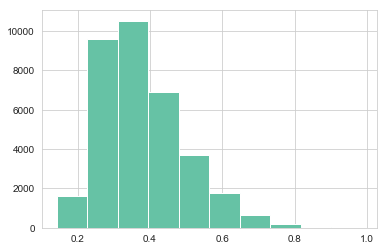

In [115]:
df['topic_pct'].hist()

In [18]:
df['topic'].value_counts(normalize = True)

4    0.313119
5    0.165473
1    0.132409
3    0.108944
2    0.104068
6    0.099040
7    0.076947
Name: topic, dtype: float64

In [19]:
df['topic'].value_counts()

4    2055
5    1086
1     869
3     715
2     683
6     650
7     505
Name: topic, dtype: int64

In [23]:
sent_body = calculate_sent_score_sent(df, 'body_clean')

In [24]:
df['body_vader'] = sent_body['full_post_score']

In [ ]:
sent_title = calculate_sent_score_sent(df_title, 'title_clean')

In [172]:
df_title['title_vader'] = sent_title

C:\Users\josh.a.peters\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_title = df.drop_duplicates('title')

In [131]:
df['count'] = 1

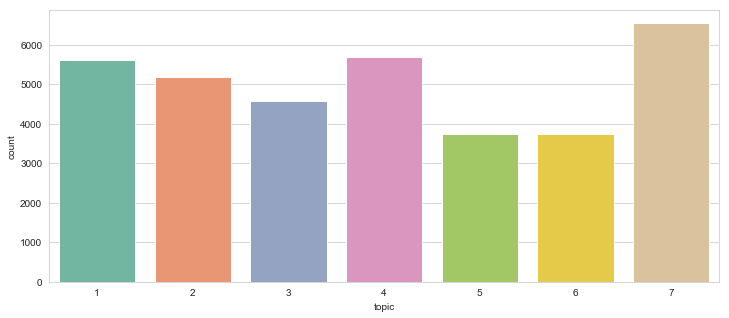

In [182]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.barplot(x= 'topic', y="count",estimator = sum,  data= df)

C:\Users\josh.a.peters\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


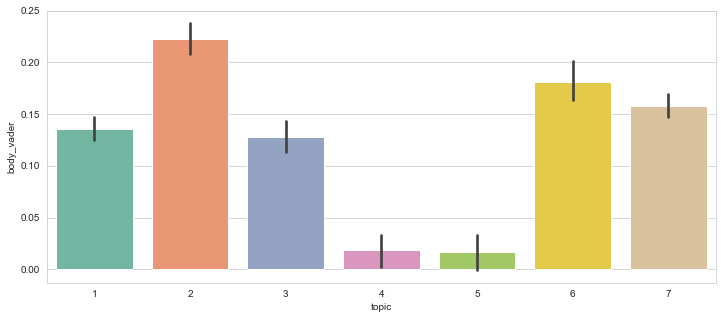

In [179]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.barplot(x= 'topic', y="body_vader", data= df)

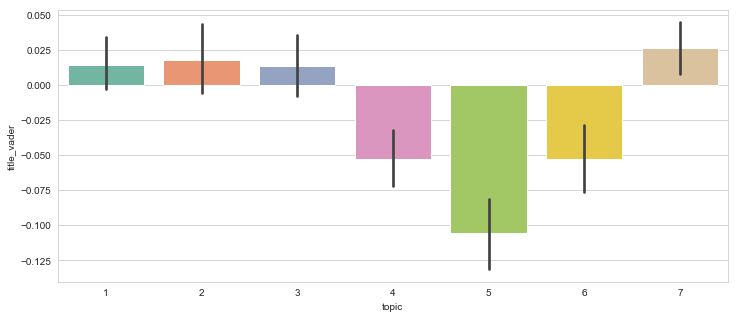

In [183]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.barplot(x= 'topic', y="title_vader", data= df_title)

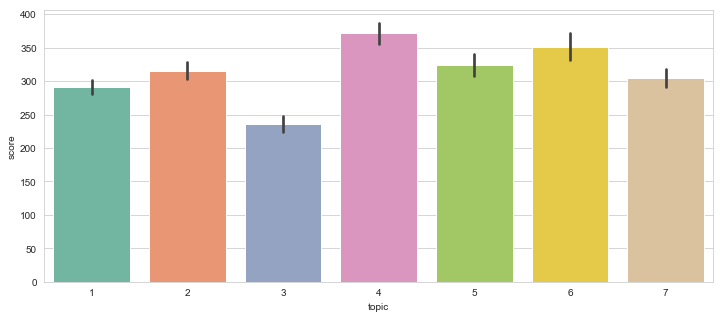

In [253]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.barplot(x= 'topic', y="score", data= df)

In [138]:
df['clean_date_sub'] = df['created'].apply(lambda x: dt.datetime.utcfromtimestamp(x)).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [139]:
df['year_sub'] = df['clean_date_sub'].str.split("-", expand = True)[0]
df['month_sub'] = df['clean_date_sub'].str.split("-", expand = True)[1]
df['day_sub'] = df['clean_date_sub'].str.split("-", expand = True)[2].str[:2]

In [140]:
#combine year and month
df['yearmonth_sub'] = df['year_sub'] + df['month_sub']
#combine year month and day
df['yearmonthday_sub'] = df['year_sub'] + df['month_sub'] + df['day_sub']

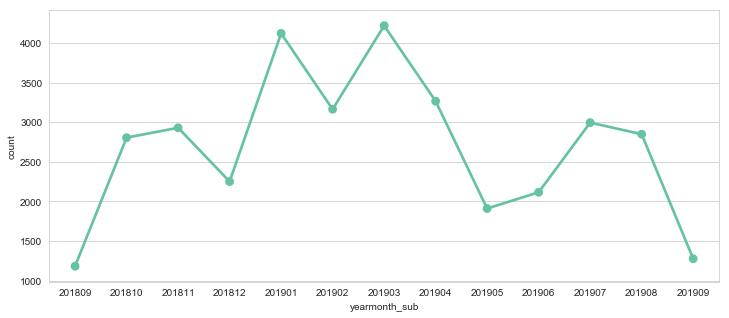

In [240]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="count", estimator = sum,  data= df)

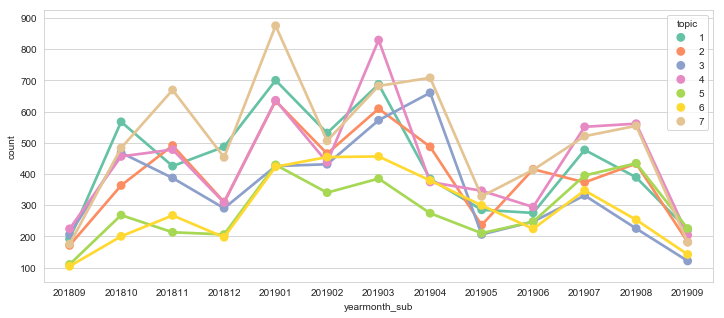

In [239]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="count", estimator = sum, hue = 'topic',  data= df)

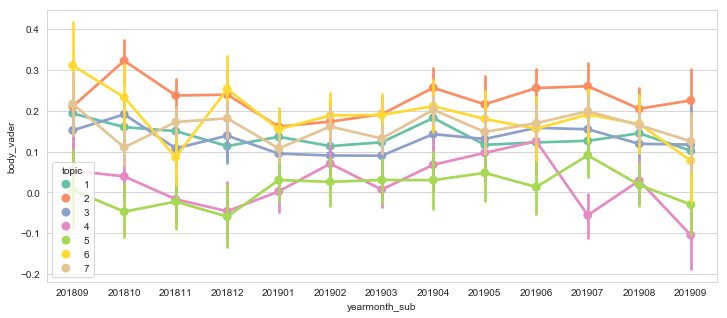

In [254]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="body_vader", hue = 'topic',  data= df)

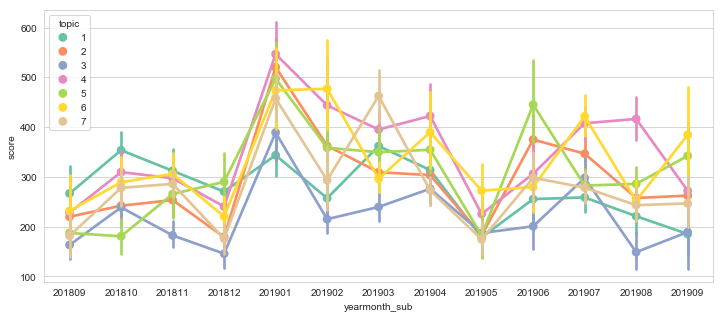

In [255]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="score", hue = 'topic',  data= df)

In [136]:
def prop(df, col1, col2, join):
    """
    (DataFrame, string, string, string --> DataFrame)
    Takes original dataframe, two columns and returns a dataframe with a column showing the proportion of the first variable in
    the second variable. For example, if the second variable is month, and first is gender, it would show the proportion of males
    and females specific to that month
    
    """
    prop_group = pd.DataFrame(df.groupby([col1, col2]).count()[join].reset_index())
    col2_totals = pd.DataFrame(df.groupby(col2).count()[join]).reset_index()
    merge = pd.merge(prop_group, col2_totals, 'outer',col2)
    merge['prop']= merge[join +'_x']/ merge[join +'_y']
    
    return merge

In [141]:
prop_sent = prop(df, 'topic', 'yearmonth_sub', 'Unnamed: 0')

In [142]:
df.groupby('topic').mean()['body_vader']

topic
1    0.135651
2    0.222762
3    0.128157
4    0.018366
5    0.016758
6    0.180871
7    0.157813
Name: body_vader, dtype: float64

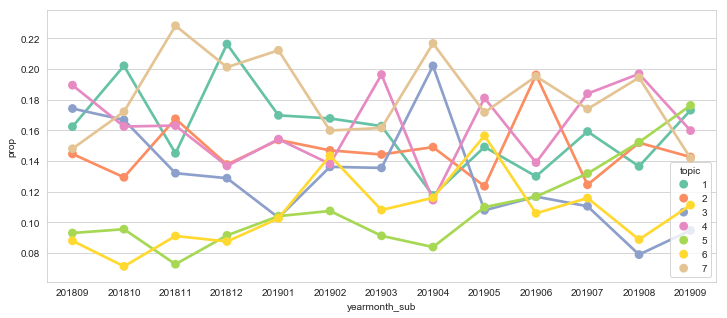

In [143]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="prop", hue = 'topic',  data= prop_sent)

In [286]:
temp_topic_df = prop_sent[prop_sent['topic'] == 1]['yearmonth_sub']


In [291]:
temp_topic_df[temp_topic_df['yearmonth_sub'] == temp_topic_df.max()]

,topic,yearmonth_sub,Unnamed: 0_x,Unnamed: 0_y,prop
84,1,201909,221,1276,0.173197
85,2,201909,182,1276,0.142633
86,3,201909,121,1276,0.094828
87,4,201909,204,1276,0.159875
88,5,201909,225,1276,0.176332
89,6,201909,142,1276,0.111285
90,7,201909,181,1276,0.141850


In [148]:
df['sent_flag'] = df['body_vader'].apply(lambda x : 'pos' if x > 0.5 else ('neg' if x < -0.5 else 'neu'))

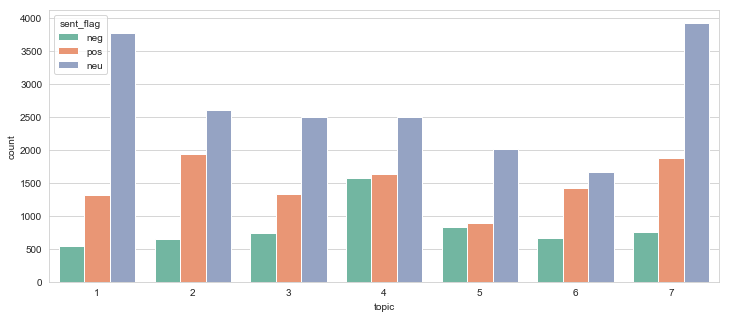

In [151]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.barplot(x= 'topic', y="count",estimator = sum, hue = 'sent_flag' ,data= df)

# Topic 1

In [181]:
df_1_title = df_title[df_title['topic'] == 1]

In [152]:
df_1 = df[df['topic'] == 1]

In [146]:
#tgetTFIDFandCount(df_title['title_clean'], (3,3))

In [154]:
df_1_sent = prop(df_1, 'sent_flag', 'yearmonth_sub', 'Unnamed: 0')

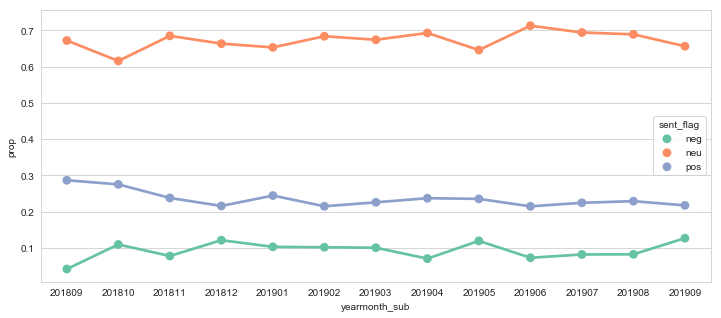

In [155]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="prop", hue = 'sent_flag',  data= df_1_sent)

In [3]:
prop_1 = prop_sent[prop_sent['topic'] == 1]

NameError: name 'prop_sent' is not defined

In [159]:
#percetn of posts mentioning stations
len(df_1[(df_1['tokenized_list'].astype(str).str.lower().str.contains('ttcstation'))])/len(df_1)

0.2179715302491103

In [161]:
df_1_neg = df_1[df_1['sent_flag'] == 'neg']

In [162]:
getTFIDFandCount(df_1_neg['tokenized_list'], (3,3))

,term,tfidf,counts
0,faulty presto machine,0.007491,4
1,presto machine break,0.007491,4
2,broken presto reader,0.005618,4
3,go negative balance,0.005618,4
4,lose presto card,0.005618,7
5,http www ttc,0.003973,4
6,www ttc ca,0.003973,4
7,mobile payment well,0.003745,4
8,hour transfer window,0.001873,4
9,crazy train presto,0.001529,4


In [163]:
df_1_pos = df_1[df_1['sent_flag'] == 'pos']

In [165]:
getTFIDFandCount(df_1_pos['body_clean'], (3,3))

,term,tfidf,counts
0,tap credit card,0.008151,12
1,use credit card,0.007397,12
2,union station free,0.005188,16
3,https wwwgotransitcom en,0.004906,12
4,en travelling with,0.004204,11
5,promotions and events,0.004204,11
6,wwwgotransitcom en travelling,0.004204,11
7,capsule exhibit union,0.003755,13
8,exhibit union station,0.003755,13
9,louis vuitton time,0.003755,13


In [31]:
tf_1 = getTFIDFandCount(df_1['tokenized_list'], (3,3))
tf_1['topic'] = 1

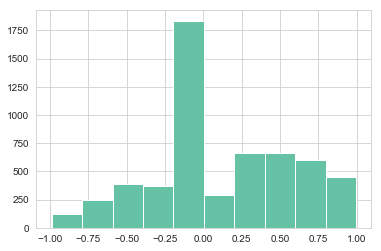

In [144]:
df_1['body_vader'].hist()

In [186]:
getTFIDFandCount(df_1_title[df_1_title['score'] > 100]['title_clean'], (3,3))


,term,tfidf,counts
0,sign project day,0.016960,8
1,bus sign project,0.009942,5
2,ttc bus sign,0.009942,5
3,amber alert issue,0.006969,2
4,board ttc bus,0.006969,2
5,nathan phillips square,0.006969,2
6,new ttc bus,0.006969,2
7,premier doug ford,0.006969,2
8,sell presto card,0.006969,2
9,ttc sign project,0.005435,2


# Topic 2

In [188]:
df_2_title = df_title[df_clean_title['topic'] == 2]

In [166]:
df_2 = df[df['topic'] == 2]

In [190]:
getTFIDFandCount(df_2_title['title_clean'], (3,3))

,term,tfidf,counts
0,toronto housing crisis,0.006942,6
1,good city live,0.005533,4
2,doug ford government,0.004149,3
3,doug ford say,0.004149,3
4,high speed rail,0.004149,3
5,say cbc news,0.004149,3
6,upload ttc subway,0.004149,3
7,go bus service,0.003744,3
8,service steve munro,0.003744,3
9,fix toronto housing,0.003069,3


In [36]:
tf_2 = getTFIDFandCount(df_2['tokenized_list'], (3,3))
tf_2['topic'] = 2

In [167]:
df_2_neg = df_2[df_2['sent_flag'] == 'neg']

In [168]:
getTFIDFandCount(df_2_neg['tokenized_list'], (3,3))

,term,tfidf,counts
0,public transit system,0.013355,11
1,world class city,0.012110,9
2,system north america,0.010705,9
3,city north america,0.009419,6
4,single family home,0.007849,6
5,transit system north,0.006410,6
6,bad transit system,0.006279,4
7,north american city,0.006279,4
8,new york city,0.005103,4
9,low density sprawl,0.004710,4


In [170]:
df_2_pos= df_2[df_2['sent_flag'] == 'pos']

In [191]:
getTFIDFandCount(df_2['tokenized_list'], (3,3))

,term,tfidf,counts
0,public transit system,0.011117,73
1,world class city,0.009884,57
2,north american city,0.006940,38
3,city north america,0.006218,35
4,single family home,0.005399,37
5,transit system world,0.005272,32
6,well public transit,0.005232,29
7,system north america,0.005080,36
8,low density area,0.004474,26
9,new york city,0.004360,25


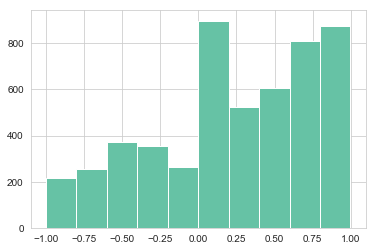

In [217]:
df_2['body_vader'].hist()

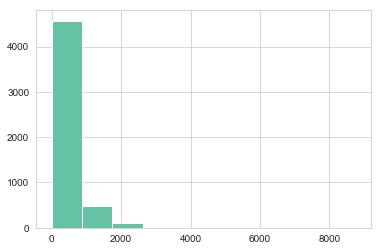

In [257]:
df_2['score'].hist()

# Topic 3

In [49]:
df_3_title = df_title[df_title['topic'] == 3]

In [171]:
df_3 = df[df['topic'] == 3]

In [51]:
tf_3 = getTFIDFandCount(df_3_title['title_clean'], (3,3))
tf_3['topic'] = 3

In [194]:
getTFIDFandCount(df_3_title['title_clean'], (3,3))

,term,tfidf,counts
0,premier doug ford,0.012329,9
1,doug ford government,0.008219,6
2,doug ford ontario,0.005479,4
3,doug ford subway,0.005479,4
4,eglinton crosstown lrt,0.005479,4
5,doug ford ttc,0.005060,4
6,downtown relief line,0.004110,3
7,mayor john tory,0.004110,3
8,ontario liberal leadership,0.004110,3
9,spadina fort york,0.004110,3


In [172]:
df_3_neg = df_3[df_3['sent_flag'] == 'neg']

In [175]:
getTFIDFandCount(df_3_neg['title_clean'], (3,3))

,term,tfidf,counts
0,premier doug ford,0.011547,5
1,doug ford subway,0.009250,5
2,scarborough subway extension,0.006928,3
3,john tory say,0.006807,4
4,relief line plan,0.006311,3
5,upload toronto subway,0.006252,3
6,subway queen park,0.006252,3
7,upload ttc subway,0.005970,3
8,mayor john tory,0.004682,3
9,billion transit funding,0.004619,2


In [177]:
df_3_pos = df_3[df_3['sent_flag'] == 'pos']

In [179]:
getTFIDFandCount(df_3_pos['body_clean'], (3,3))

,term,tfidf,counts
0,downtown relief line,0.029054,41
1,scarborough subway extension,0.012071,18
2,toronto city council,0.008141,12
3,https enwikipediaorg wiki,0.007547,19
4,relief line would,0.007545,13
5,plan relief line,0.007455,12
6,https wwwtheglobeandmailcom canada,0.002760,26
7,wwwtheglobeandmailcom canada article,0.002281,25
8,https nowtorontocom news,0.001645,11
9,article doug ford,0.001424,11


In [195]:
getTFIDFandCount(df_3['tokenized_list'], (3,3))

,term,tfidf,counts
0,ttcstation subway extension,0.013597,66
1,subway subway subway,0.012704,61
2,toronto city council,0.007094,35
3,toronto transit commission,0.007050,46
4,ttcstation ttcstation ttcstation,0.005579,40
5,exclude subreddit urllink,0.001984,30
6,exclude urllink exclude,0.001984,30
7,faq information urllink,0.001984,30
8,information urllink source,0.001984,30
9,subreddit urllink faq,0.001984,30


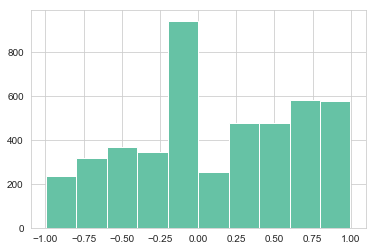

In [258]:
df_3['body_vader'].hist()

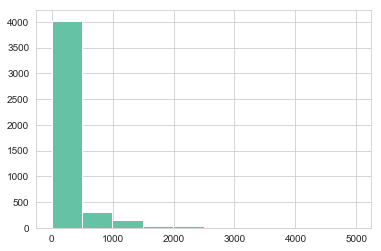

In [259]:
df_3['score'].hist()

# Topic 4

In [48]:
df_4_title = df_title[df_title['topic'] == 4]

In [53]:
df_4 = df[df['topic'] == 4]

In [198]:
getTFIDFandCount(df_4_title['title_clean'], (3,3))

,term,tfidf,counts
0,premier doug ford,0.005429,8
1,doug ford say,0.003286,5
2,injury track level,0.002948,4
3,nathan phillips square,0.002948,4
4,bus sign project,0.002280,5
5,doug ford government,0.002211,3
6,line bloor danforth,0.002211,3
7,ttc subway operator,0.002211,3
8,sign project day,0.001816,4
9,ttc bus sign,0.001816,4


In [54]:
tf_4 = getTFIDFandCount(df_4['tokenized_list'], (3,3))
tf_4['topic'] = 4

In [199]:
getTFIDFandCount(df_4['tokenized_list'], (3,3))

,term,tfidf,counts
0,ttcstation ttcstation ttcstation,0.003691,23
1,ttc fare inspector,0.002876,18
2,jump front subway,0.002812,18
3,mental health issue,0.002636,16
4,mentally ill people,0.001885,12
5,ttc bus driver,0.001757,10
6,ride public transit,0.001535,9
7,injury track level,0.001406,8
8,ride ttc day,0.001406,8
9,toronto transit commission,0.001406,9


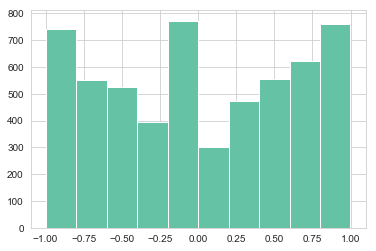

In [219]:
df_4['body_vader'].hist()

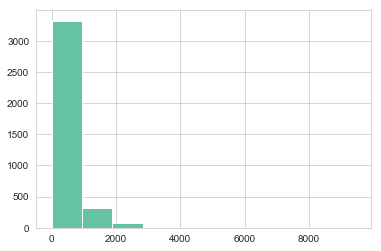

In [261]:
df_5['score'].hist()

# Topic 5

In [200]:
df_5_title = df_title[df_title['topic'] == 5]

In [56]:
df_5 = df[df['topic'] == 5]

In [202]:
getTFIDFandCount(df_5_title['title_clean'], (3,3))

,term,tfidf,counts
0,carbon tax sticker,0.009804,10
1,hit and run,0.009384,8
2,park bike lane,0.004902,4
3,anti carbon tax,0.004241,5
4,get around city,0.003676,3
5,king street pilot,0.003676,3
6,ttc bus driver,0.003676,3
7,suffers serious injury,0.003375,3
8,gas pump sticker,0.002815,3
9,gas station ontario,0.002751,3


In [57]:
tf_5 = getTFIDFandCount(df_5['tokenized_list'], (3,3))
tf_5['topic'] = 5

In [203]:
getTFIDFandCount(df_5['tokenized_list'], (3,3))

,term,tfidf,counts
0,self drive car,0.004291,28
1,highway traffic act,0.004023,16
2,ttcstation ttcstation ttcstation,0.003754,17
3,transit enforcement officer,0.003218,12
4,ttc bus driver,0.003218,12
5,automatic train control,0.002950,11
6,ttcstation street pilot,0.002950,13
7,stop red light,0.002414,10
8,single occupant vehicle,0.002145,11
9,toronto police service,0.001915,8


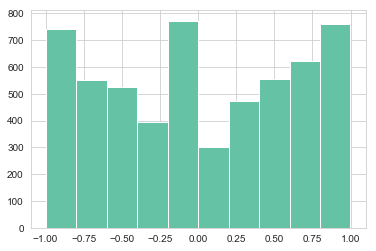

In [220]:
df_4['body_vader'].hist()

# Topic 6

In [204]:
df_6_title = df_title[df_title['topic'] == 6]

In [187]:
df_6 = df[df['topic'] == 6]

In [206]:
getTFIDFandCount(df_6_title['title_clean'], (3,3))

,term,tfidf,counts
0,doug ford government,0.006910,6
1,beer corner store,0.006075,5
2,gas pump sticker,0.004860,4
3,premier doug ford,0.004528,5
4,anti carbon tax,0.004117,4
5,doug ford make,0.003645,3
6,doug ford say,0.003645,3
7,federal carbon tax,0.003645,3
8,health care system,0.003645,3
9,protest osap change,0.003645,3


In [188]:
df_6_neg = df_6[df_6['sent_flag'] == 'neg']

In [189]:
getTFIDFandCount(df_6_neg['tokenized_list'], (3,3))

,term,tfidf,counts
0,raise property taxis,0.011833,11
1,cut cap trade,0.010165,7
2,low income people,0.008709,7
3,system north america,0.007530,7
4,increase class size,0.007335,6
5,carbon tax sticker,0.007181,6
6,distance base fare,0.006985,8
7,toronto city council,0.006506,7
8,safe injection site,0.006410,7
9,transit system north,0.006158,6


In [190]:
df_6_pos = df_6[df_6['sent_flag'] == 'pos']

In [191]:
getTFIDFandCount(df_6_pos['tokenized_list'], (3,3))

,term,tfidf,counts
0,transit tax credit,0.009472,16
1,pay fair share,0.008594,14
2,low income people,0.008008,14
3,public transit free,0.007072,10
4,minimum wage job,0.006023,11
5,property tax increase,0.005233,9
6,upper middle class,0.005080,8
7,raise property taxis,0.004725,8
8,people pay taxis,0.004612,10
9,minimum wage worker,0.004269,8


In [60]:
tf_6 = getTFIDFandCount(df_6['tokenized_list'], (3,3))
tf_6['topic'] = 6

In [207]:
getTFIDFandCount(df_6['tokenized_list'], (3,3))

,term,tfidf,counts
0,raise property taxis,0.006601,29
1,low income people,0.006142,26
2,transit tax credit,0.005406,27
3,pay fair share,0.004709,20
4,public transit system,0.004592,19
5,minimum wage job,0.004397,22
6,toronto city council,0.003395,13
7,fund transit system,0.003233,16
8,public transit tax,0.003158,17
9,property tax increase,0.003063,13


# Topic 7

In [208]:
df_7_title = df_title[df_title['topic'] == 7]

In [96]:
df_7 = df[df['topic'] == 7]

In [97]:
df_7 = df_7[~df_7['body_clean'].isnull()]

In [210]:
getTFIDFandCount(df_7_title['title_clean'], (3,3))

,term,tfidf,counts
0,go train service,0.005820,6
1,st clair west,0.003880,4
2,toronto housing market,0.003880,4
3,ontario science centre,0.003584,4
4,go train station,0.002910,3
5,humber bay shore,0.002910,3
6,king street pilot,0.002910,3
7,nathan phillips square,0.002910,3
8,premier doug ford,0.002910,3
9,would like see,0.002910,3


In [99]:
tf_7= getTFIDFandCount(df_7['body_clean'], (3,3))
tf_7['topic'] = 7

In [211]:
getTFIDFandCount(df_7['body_clean'], (3,3))

,term,tfidf,counts
0,within walk distance,0.007296,55
1,take go train,0.005135,36
2,downtown relief line,0.004873,34
3,st clair west,0.004770,33
4,scarborough town centre,0.003785,28
5,go train station,0.003776,26
6,outside rush hour,0.003625,25
7,dundas west station,0.003528,25
8,single family home,0.003138,24
9,they re go,0.003067,20


In [106]:
all_tf = pd.concat([tf_1,tf_2, tf_3, tf_4, tf_5, tf_6,tf_7])

In [107]:
all_tf.to_csv('C:/Users/josh.a.peters/TransitSocialMedia/Data/all_tfidf.csv')

# 

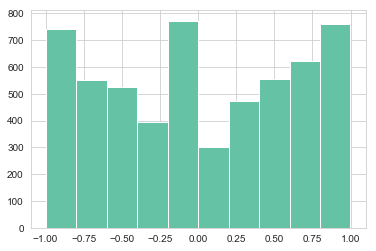

In [221]:
df_4['body_vader'].hist()

In [268]:
df.to_csv('C:/Users/josh.a.peters/TransitSocialMedia/Data/reddit_df_topics_sentiment.csv')

In [161]:
def calculate_sent_score_sent(df, column):
    """
    (DataFrame, string -->list)

    For a given column containing text, calculate the sentiment score for each sentence, and take the average of the whole string
    """
    #initialize vader
    sia = SIA()
    #empty lists to store results
    results = []
    results_score = []
    results_sent = []
    #go through each text value and each sentence, and apply vader
    for value in df[column].astype(str):
        if value!= 'nan':
            sent_list = sent_tokenize(value)
            sent_results = []
            score = []
            for i in range(len(sent_list)):
                pol_score = sia.polarity_scores(sent_list[i])
                pol_score['text'] = sent_list[i]
                sent_results.append(pol_score)
                score.append(sent_results[i]['compound'])
            if len(sent_list) >0:
                full_score = (sum(score))/(len(score))
            else:
                full_score = sum(score)
            results.append(full_score)
            results_score.append(score)
            results_sent.append(sent_list)

        else:
            results.append(None)
            results_score.append(None)
            results_sent.append(None)
    #add to df
   # df['full_post_score'] = results
    #df['full_post_all_scores'] = results_score
    #df['full_post_all_sentences'] = results_sent


    return results

In [21]:
getTFIDFandCount(df_clean[df_clean['topic'] == 1]['body_clean'], (3,3))
    

,term,tfidf,counts
0,high suicide rate,0.010146,5
1,take public transit,0.009547,4
2,mental health issue,0.008876,5
3,late term abortion,0.008872,8
4,adult gender identity,0.003648,6
5,process sex reassignment,0.003648,6
6,provide basic necessity,0.003358,7
7,sex reassignment surgery,0.003126,4
8,suggest sex reassignment,0.002985,5
9,basic necessity life,0.002908,6


In [17]:
def getTFIDFandCount(df_col, ngramrange):
    """(DataFrame, tuple --> DataFrame)
    Takes a column of a dataframe and the range for n-gram analysis to find the TF-IDF for each
    n-gram in the column.

    Returns a DataFrame of the top 10 n-grams, TF-IDF score, and actual count of n-gram appearance.
    """
    cv=CountVectorizer(ngram_range=ngramrange, max_features=15)
    word_count_vector=cv.fit_transform(df_col.unique())
    feature_names = cv.get_feature_names()

    # Transforming top 400 most common words to produce TF-IDF score
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    tfidf_vector=tfidf_transformer.transform(word_count_vector)

    # Combining TF-IDF score with the words into a dictionary
    weights = np.asarray(tfidf_vector.mean(axis=0)).ravel().tolist()
    df_tfidf = pd.DataFrame(weights, index=feature_names, columns=["tfidf"])
    df_tfidf = df_tfidf.sort_values(by=["tfidf"],ascending=False).reset_index()
    df_tfidf.rename(index=str, columns={"index": "term"}, inplace=True)

    # Counting the actual number of occurances and appending to dictionary of word
    # with TF-IDF value
    count_list = word_count_vector.toarray().sum(axis=0)
    actual_count_dict = {"term": feature_names, "counts": count_list}
    actual_count_df = pd.DataFrame.from_records(actual_count_dict)
    tfidf_and_count = pd.merge(df_tfidf, actual_count_df, on='term', how='left')
    return tfidf_and_count

def add_tfidf_column(full_df, month, suffix):
    """(DataFrame, string, string --> DataFrame)
    Takes the filtered dataframe to generate TFIDF scores for, as well as the month
    and suffix relating to what the dataframe has been filtered for (i.e. mental health
    or sarcastic posts).

    Returns the top 10 TFIDF for the filtered dataframe, for that month.
    """
    tfidf_df = getTFIDFandCount(full_df["Post_Clean"],(2, 4))
    tfidf_df = tfidf_df[:10]
    tfidf_df = tfidf_df.add_suffix(suffix)
    return tfidf_df

def create_monthly_tfidf(full_df):
    """(DataFrame --> DataFrame)
    Taking the Reddit dataframe and combining it with the dataframe of TF-IDF values
    so each month is matched up with the most popular TF-IDFs for that month.

    Returns a dataframe with a new column for most popular TF-IDFs of that month.
    """
    all_tfidf = pd.DataFrame()
    # Filters out empty posts as well as mental health monday posts, since they
    # skew the popular word count

    full_df = full_df[~full_df["Post_Clean"].isnull()]
    full_df = full_df[~full_df["Post_Clean"].str.contains("mental health monday")]

    # Getting the unique month and years for the reddit data and iterating through
    # each month-year combination
    all_time = full_df.yearmonth_sub.unique()
    for month in all_time:
        filtered = full_df[full_df.yearmonth_sub == month]
        # Generate top 10 monthly TF-IDF for all posts
        tfidf_df = getTFIDFandCount(filtered["Post_Clean"],(2, 4))
        tfidf_df = tfidf_df[:10]
        tfidf_df["yearmonth_sub"] = month
        # Generate top 10 monthly TF-IDF for all MH posts
        mh_filtered = filtered[filtered.mh_combined_updated > 0.7]
        if len(mh_filtered) > 1:
            mh_tfidf_df = add_tfidf_column(mh_filtered, month, '_mh')
            tfidf_df = pd.concat([tfidf_df, mh_tfidf_df], axis=1, sort=True)
        # Generate top 10 monthly TF-IDF for all sarcastic posts
        sarc_filtered = filtered[filtered.prob_sarc > 0.8]
        if len(sarc_filtered) > 1:
            sarc_tfidf_df = add_tfidf_column(sarc_filtered, month, '_sarc')
            tfidf_df = pd.concat([tfidf_df, sarc_tfidf_df], axis=1, sort=True)
        # Adding filtered TFIDF columns to master TFIDF dataframe with the top
        # terms for all posts
        all_tfidf = all_tfidf.append(tfidf_df, ignore_index=True, sort=True)
        
    return all_tfidf
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = str(text).lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    text = re.sub(r'([.,?!*()])', "", text)
    return(text)


In [18]:
def clean_html(df_subs_clean):
    """
    (Dataframe --> DataFrame)
    Cleans up any redit values that were not converted propoerly from html or utf - 8 when pulled from the internet

    """
    #define class that strips html using html parser
    class MLStripper(HTMLParser):
        def __init__(self):
            self.reset()
            self.strict = False
            self.convert_charrefs= False
            self.fed = []
        def handle_data(self, d):
            self.fed.append(d)
        def get_data(self):
            return ''.join(self.fed)
    #define function that calls stripper
    def strip_tags(html):
        s = MLStripper()
        s.feed(html)
        return s.get_data()


    #apply encoding from windows to utf to get some garbage characters
    df_subs_clean['body_clean'] = df_subs_clean['body_clean'].str.encode("Windows-1252", 'ignore').str.decode('utf-8', 'ignore').str.replace('#x200B;',"")
    #apply htm function
    df_subs_clean['body_clean'] = df_subs_clean['body_clean'].astype(str).str.replace('\n', "").apply(strip_tags)
    df_subs_clean['body_clean'] = df_subs_clean['body_clean'].astype(str).str.replace('\r', "").apply(strip_tags)


    return df_subs_clean


In [19]:
def calculate_sent_score_sent(df, column):
    """
    (DataFrame, string -->list)

    For a given column containing text, calculate the sentiment score for each sentence, and take the average of the whole string
    """
    #initialize vader
    sia = SIA()
    #empty lists to store results
    results = []
    results_score = []
    results_sent = []
    #go through each text value and each sentence, and apply vader
    for value in df[column].astype(str):
        if value!= 'nan':
            sent_list = sent_tokenize(value)
            sent_results = []
            score = []
            for i in range(len(sent_list)):
                pol_score = sia.polarity_scores(sent_list[i])
                pol_score['text'] = sent_list[i]
                sent_results.append(pol_score)
                score.append(sent_results[i]['compound'])
            if len(sent_list) >0:
                full_score = (sum(score))/(len(score))
            else:
                full_score = sum(score)
            results.append(full_score)
            results_score.append(score)
            results_sent.append(sent_list)

        else:
            results.append(None)
            results_score.append(None)
            results_sent.append(None)
    #add to df
    df['full_post_score'] = results
    df['full_post_all_scores'] = results_score
    df['full_post_all_sentences'] = results_sent


    return df